# Investigating the performance of Technology-Enhanced Atmospheric Moistening (TEAM)

*Sarah Warnau (sarah.warnau@wur.nl), 2025*

With freshwater scarcity a pressing issue, new ways of increasing freshwater availabilty are being researched. One such idea is using technologies to enhance the atmospheric moisture content by evaporating seawater. The goal is to stimulate precipitation downwind over coastal drylands (1). Two different types of technologies are considered (Figure 1):
1. A spray technology where seawater droplets are sprayed and they evaporate by using heat from the atmsphere.
2. A interfacial solar evaporation technology where solar radiation is localised on a dark surface which is kept saturated with water.

To investigate the effect of enhanced moistening on the ABL, the Large Eddy Simulation (LES) code microHH is used (2). In LES the Navier-Stokes equations are solved numerically on a grid where the smallest eddies are parametrized. In the current setup, the grid resolution in all directions (x, y, z) is 10 m. We consider a typical marine boundary layer near the Spanish Mediterranean coast, with a wind velocity $u=4$ m/s. The sea surface is modelled as a flat surface with a low roughness lenght, a constant temperature ($\theta_s=297.5$ K) and specific humidity at saturation.

There are two atmospheric cases: a mean atmosphere case "MEAN" and a dry-hot case "DRYHOT" where the specific humidity is decreased with 5 g/kg and the atmospheric temperature is increased with 3 K. Furthermore, per case there are three different model runs: 1. a reference run "REF", 2. a run with a spray technology "SPR" which is implemented as a strong source of rain droplets at $x=1$ km, $z=100$ m, 3. a run with a solar technology "SOL" which is implemented as a heated surface from $x:0-1$ km where the surface temperature is calculated from the surface energy balance. The technologies span the whole domain width in the y-direction. We analyze the time-mean (5 minutes), y-mean results.

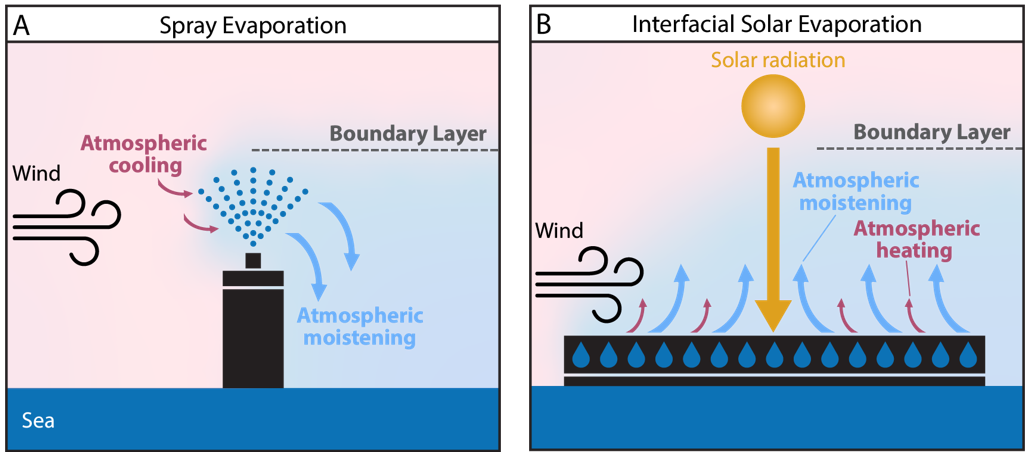

*Figure 1: Two technology types considered to enhance atmospheric moisture. Adapted from (1).*

**References**
1.  Warnau, S. N.; Theeuwen, J. J. E.; Sadeghi, G.; Benedict, I.; Hamelers, B. H. V. M.; van Heerwaarden, C. C. Technology-Enhanced Atmospheric Moistening (TEAM) for More Precipitation: A Perspective. Environ. Sci. Technol. 2025. https://doi.org/10.1021/acs.est.5c06428.
2. van Heerwaarden, C. C.; van Stratum, B. J. H.; Heus, T.; Gibbs, J. A.; Fedorovich, E.; Mellado, J. P. MicroHH 1.0: A Computational Fluid Dynamics Code for Direct Numerical Simulation and Large-Eddy Simulation of Atmospheric Boundary Layer Flows. Geoscientific Model Development 2017, 10 (8), 3145–3165. https://doi.org/10.5194/gmd-10-3145-2017.


In [ ]:
%pip install netCDF4 xarray plotly nbformat

import numpy as np
import xarray as xr
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os

# other
sigma=5.67e-8 # Stefan Boltzmann constant

def load_ncdata():
    ds = xr.open_dataset("data_small.nc", engine="netcdf4").sel(z=slice(0,600), drop=True)
    return ds

ds = load_ncdata()

Look at the potential temperature and specific humidity slices of the reference runs of the two atmospheric cases.

In [ ]:
x = ds["x"].values/1000
z = ds["z"].values
colormap1 = 'Plasma'
colormap2 = 'RdBu'
ATMS = ['MEAN', 'DRYHOT']
EXPS = ['SPR', 'SOL']

In [ ]:
exp = 'REF'

theta = {atm: ds.sel(atm=atm, exp=exp)['theta'].values for atm in ATMS}
q     = {atm: ds.sel(atm=atm, exp=exp)['q'].values*1000 for atm in ATMS}

# Combined ranges
all_t = np.concatenate([theta[atm].flatten() for atm in ATMS])
all_q = np.concatenate([q[atm].flatten() for atm in ATMS])
thetamin, thetamax = np.nanpercentile(all_t, 1), np.nanpercentile(all_t, 99)
qmin, qmax         = np.nanpercentile(all_q, 1), np.nanpercentile(all_q, 99)

# --- Create figure ---
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=["Potential temperature field", "Specific humidity field"],
    horizontal_spacing=0.1,
)

# Initial ATM shown
atm0 = 'MEAN'

# --- Add traces (one for θ, one for q) ---
fig.add_trace(
    go.Contour(
        x=x, y=z, z=theta[atm0],
        name="θ",
        zmin=thetamin, zmax=thetamax,
        colorscale=colormap1,
        colorbar=dict(x=0.47, title='θ [K]'),
    ),
    row=1, col=1
)

fig.add_trace(
    go.Contour(
        x=x, y=z, z=q[atm0],
        name="q",
        zmin=qmin, zmax=qmax,
        colorscale=colormap1,
        colorbar=dict(title='q [g/kg]'),
    ),
    row=1, col=2
)

# --- Buttons to update z-values ---
buttons = []
for atm in ATMS:
    buttons.append(
        dict(
            label=atm,
            method="update",
            args=[
                {
                    "z": [
                        theta[atm],  # update θ
                        q[atm]       # update q
                    ]
                },
                # {"title": f"Atmospheric case = {atm}"}
            ]
        )
    )

fig.update_layout(
    updatemenus=[
        dict(
            type="buttons",
            direction="left",
            x=0.5, xanchor="center",
            y=1.25, yanchor="top",
            buttons=buttons,
            showactive=True,
        )
    ]
)

fig.update_yaxes(title="z [m]", col=1)
fig.update_xaxes(title="x [km]", row=1, col=1)
fig.update_xaxes(title="x [km]", row=1, col=2)

# fig.write_html("Fig1.html", full_html=False)
fig

**Question:** How would you describe the ABL in each case? What mechanism explains the state of the ABL in each case? 

**Answer:**

MEAN case: Mixed ABL of approximately 400 m. Mixed by shear (surface fluxes are low over the sea).

DRYHOT case: Still there is a mixed layer (up to 350 m), but now we observe a shallow (approximately 90 m) stable layer with lower temperatures and higher humidity. It forms because the atmosphere is warmer than the sea surface in this case, resulting in a heat flux into the surface.

Now take a look at the turbulent heat and moisture fluxes ($\overline{w' \theta'}$ and $\overline{w' q'}$).

In [ ]:
exp = 'REF'

wtheta = {atm: ds.sel(atm=atm, exp=exp)['wtheta'].values for atm in ATMS}
wq     = {atm: ds.sel(atm=atm, exp=exp)['wq'].values*1000 for atm in ATMS}

# Combined ranges
all_t = np.concatenate([wtheta[atm].flatten() for atm in ATMS])
all_q = np.concatenate([wq[atm].flatten() for atm in ATMS])
wthetamax = np.nanpercentile(np.abs(all_t), 99)
wqmax     = np.nanpercentile(np.abs(all_q), 99)

# --- Create figure ---
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=["Turbulent heat flux field", "Turbulent humidity flux field"],
    horizontal_spacing=0.1,
)

# Initial ATM shown
atm0 = 'MEAN'

# --- Add traces (one for θ, one for q) ---
fig.add_trace(
    go.Contour(
        x=x, y=z, z=wtheta[atm0],
        zmin = -wthetamax, zmax =  wthetamax,
        name="w'θ'",
        colorscale=colormap2,
        colorbar=dict(x=0.47, title="w'θ' [K m/s]"),
    ),
    row=1, col=1
)

fig.add_trace(
    go.Contour(
        x=x, y=z, z=wq[atm0],
        zmin = -wqmax, zmax =  wqmax,
        name="w'q'",
        colorscale=colormap2,
        colorbar=dict(title="w'q' [g/kg m/s]"),
    ),
    row=1, col=2
)

# --- Buttons to update z-values ---
buttons = []
for atm in ATMS:
    buttons.append(
        dict(
            label=atm,
            method="update",
            args=[
                {
                    "z": [
                        wtheta[atm],  # update θ
                        wq[atm]       # update q
                    ]
                },
                # {"title": f"Atmospheric case = {atm}"}
            ]
        )
    )

fig.update_layout(
    updatemenus=[
        dict(
            type="buttons",
            direction="left",
            x=0.5, xanchor="center",
            y=1.25, yanchor="top",
            buttons=buttons,
            showactive=True,
        )
    ]
)

fig.update_yaxes(title="z [m]", col=1)
fig.update_xaxes(title="x [km]", row=1, col=1)
fig.update_xaxes(title="x [km]", row=1, col=2)

# fig.write_html("Fig2.html", full_html=False)
fig

**Question:** For the MEAN case, why is the humidity flux positive throughout the ABL, while the heat flux is positive in the lower part, and negative in the upper part?

**Answer:** 
- In the case of turbulent transport of heat a positive flux shows either warm air transport upwards or cold air downwards, while a negative flux shows warm air transport downwards or cold air transport upwards. In this case, the surface is heating the atmosphere slightly resulting in $\overline{w' \theta'} > 0$ while we have warm air entrainment into the ABL from the top resulting in $\overline{w' \theta'} < 0$.
- In the case of turbulent transport of moisture we have either moist air transport upwards or dry air downwards when the flux is postive, or dry air upwards or moist air downwards for negative fluxes. Since moisture is added from the surface and dry air is entrained into the ABL from the top  $\overline{w' q'} > 0$ in the whole ABL.

**Question:** For the DRYHOT case, considering the fluxes, how would you describe the mixed layer (up to 350 m)?

**Answer:** The mixed layer is a residual layer, since it is not directly impacted by the surface fluxes.

Now we will investigate what happens with the ABL when we add moisture with a spraying technology (SPR) or an interfacial solar evaporation technology (SOL). Remember how the different technologies are implemented in the model and look at the figures below.

In [ ]:
atm_list = ["MEAN", "DRYHOT"]

# Precompute the contour data for both atmospheres
contour_data = {
    atm: ds.sel(atm=atm, exp="SPR")["qr"].values * 1000
    for atm in atm_list
}

qrmax = np.nanmax(np.array([contour_data[atm] for atm in atm_list]).flatten())

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=[
        "Rain water field (SPR)", 
        "Surface (SOL) & 5 m (REF) temperatures"
    ],
    horizontal_spacing=0.15,
)

default_atm = atm_list[0]

fig.add_trace(
    go.Contour(
        x = ds['x'] / 1000,
        y = ds['z'],
        z = contour_data[default_atm],
        name="qr",
        zmin=0,
        zmax=qrmax,
        colorbar = dict(x=0.45, title="qr [g/kg]"),
        colorscale = "PuBuGn",
    ),
    row=1, col=1
)

for i, atm_name in enumerate(["MEAN", "DRYHOT"]):
    # SOL surface temperature
    fig.add_trace(
        go.Scatter(
            x = ds['x'] / 1000,
            y = ds.sel(atm=atm_name, exp="SOL")['thl_bot'],
            mode = "lines",
            name = f"{atm_name} surface, SOL",
            line = dict(dash=["solid", "dash"][i], color=["black", "hotpink"][i])
        ),
        row=1, col=2
    )

    # REF 5 m temperature
    fig.add_trace(
        go.Scatter(
            x = ds['x'] / 1000,
            y = ds.sel(atm=atm_name, exp="REF", z=5)['theta'],
            mode = "lines",
            name = f"{atm_name} 5 m, REF",
            line = dict(dash=["solid", "dash"][i], color=["grey", "pink"][i])
        ),
        row=1, col=2
    )

fig.update_layout(
    updatemenus=[
        dict(
            type="buttons",
            direction="left",
            x=0.1,
            y=1.15,
            buttons=[
                dict(
                    label=atm_name,
                    method="restyle",
                    args=[
                        {"z": [contour_data[atm_name]]},  # update the contour only
                        [0]  # trace index 0 = left contour
                    ],
                )
                for atm_name in atm_list
            ],
            showactive=True
        )
    ]
)

fig.update_xaxes(title_text="x [km]")
fig.update_yaxes(title_text="z [m]", row=1, col=1)
fig.update_yaxes(title_text="θ [K]", row=1, col=2)


fig.update_layout(
    width=1600,
    height=450,
)

# fig.write_html("Fig3.html", full_html=False)
fig

Both technologies have the goal to increase the humidity of the ABL, but they do this in different ways.

**Question:** How will the technologies impact the temperature? What impact will this have on the ABL in the two different cases?

Check your answers with the figures below.

In [ ]:
# ---------- Precompute all fields ----------
theta     = {(atm, exp): ds.sel(atm=atm, exp=exp)['theta'].values
             for atm in ATMS for exp in EXPS}
q         = {(atm, exp): ds.sel(atm=atm, exp=exp)['q'].values*1000
             for atm in ATMS for exp in EXPS}
dtheta    = {(atm, exp): (ds.sel(atm=atm, exp=exp)['theta'] -
                          ds.sel(atm=atm, exp='REF')['theta']).values
             for atm in ATMS for exp in EXPS}
dq        = {(atm, exp): (ds.sel(atm=atm, exp=exp)['q'] -
                          ds.sel(atm=atm, exp='REF')['q']).values*1000
             for atm in ATMS for exp in EXPS}

# Limits
all_t = np.concatenate([theta[key].flatten() for key in theta])
all_q = np.concatenate([q[key].flatten() for key in q])
thetamin, thetamax = np.nanpercentile(all_t, 1), np.nanpercentile(all_t, 99)
qmin, qmax         = np.nanpercentile(all_q, 1), np.nanpercentile(all_q, 99)
all_dtheta = np.concatenate([np.abs(dtheta[key]).flatten() for key in dtheta])
all_dq     = np.concatenate([np.abs(dq[key]).flatten()     for key in dq])
dtheta_max = np.nanpercentile(all_dtheta, 99)
dq_max     = np.nanpercentile(all_dq, 99)

# Initial selection
atm0 = 'MEAN'
exp0 = 'SPR'

# ---------- Create figure ----------
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=[
        "Potential temperature", "Specific humidity",
        "Δθ (exp - REF)", "Δq (exp - REF)"
    ],
    horizontal_spacing=0.1, vertical_spacing=0.25
)

# --- Add initial traces ---
fig.add_trace(go.Contour(
        x=x, y=z, z=theta[(atm0, exp0)],
        zmin=thetamin, zmax=thetamax,
        name="θ",
        colorscale=colormap1, 
        colorbar=dict(len=0.4, x=0.47, y=0.85, title="θ [K]"),
    ), row=1, col=1)

fig.add_trace(go.Contour(
        x=x, y=z, z=q[(atm0, exp0)],
        zmin=qmin, zmax=qmax,
        name="q",
        colorscale=colormap1,
        colorbar=dict(len=0.4, y=0.85, title="q [g/kg]"),
    ), row=1, col=2)

fig.add_trace(go.Contour(
        x=x, y=z,
        z=dtheta[(atm0, exp0)], zmin=-dtheta_max, zmax=dtheta_max,
        name="Δθ",
        colorscale=colormap2,
        colorbar=dict(len=0.4, x=0.47, y=0.20, title="Δθ [K]"),
    ), row=2, col=1)

fig.add_trace(go.Contour(
        x=x, y=z,
        z=dq[(atm0, exp0)], zmin=-dq_max, zmax=dq_max,
        name="Δq",
        colorscale=colormap2,
        colorbar=dict(len=0.4, y=0.20, title="Δq [g/kg]"),
    ), row=2, col=2)


buttons = []
for atm, exp in [('MEAN', 'SPR'), ('MEAN', 'SOL'), ('DRYHOT', 'SPR'), ('DRYHOT', 'SOL')]:
    buttons.append(
        dict(
            label=f"{atm}|{exp}",
            method="update",
            args=[
                {
                    "z": [
                        theta[(atm, exp)],
                        q[(atm, exp)],
                        dtheta[(atm, exp)],
                        dq[(atm, exp)]
                    ]
                }
            ]
        )
    )


fig.update_layout(
    updatemenus=[
        dict(
            type="buttons",
            direction="left",
            buttons=buttons,
            x=0.5, xanchor="center",
            y=1.25, yanchor="top",
            showactive=True
        )
    ]
)

fig['layout']['yaxis1'].update(title=dict(text='z [m]'))
fig['layout']['yaxis3'].update(title=dict(text='z [m]'))
fig['layout']['xaxis3'].update(title=dict(text='x [km]'))
fig['layout']['xaxis4'].update(title=dict(text='x [km]'))

# fig.write_html("Fig4.html", full_html=False)
fig

**Answer:** 
- SPR cools the atmosphere. This cooling causes the density to increase. 
    - In the MEAN case a cold, moist, and stable internal boundary layer forms. 
    - In the DRYHOT case, the ABL already was stable, but the stability is increased (stronger $\theta$ gradient).
- SOL heats the atmosphere. This heating locally increases the buoyancy.
    - In the MEAN case this increase in buoyancy causes the ABL to grow convectively. This is most clear in the difference plots (lower row) where you can see that there is cooling and moistening above 400 m. Because of the the ABL growth, warm, dry air is entrained into the ABL.
    - in the DRYHOT case, we observe that the increased buoyancy is strong enough to mix the stable ABL into the residual layer above and even a little higher, as also observed in the MEAN case.

**Question:** Considering the part of the domain near the surface directly impacted by the enhanced moistening, determine and interpret the stability regimes in the case of the DRYHOT atmosphere for all experiments (REF, SPR, SOL). Make use of the figure below. Hint: you can zoom in to the relevant part of the domain.

In [ ]:
####################################################################
# make dropdown menu for exp = ['REF','SPR', 'SOL']
# exp = 'REF'
####################################################################
EXPS = ['REF','SPR', 'SOL']
atm = 'DRYHOT' 

uw     = {exp: ds.sel(atm=atm, exp=exp)['uw'].values for exp in EXPS}
dudz   = {exp: ds.sel(atm=atm, exp=exp)['u'].differentiate('z').values*1000/10 for exp in EXPS}
wthetav = {exp: ds.sel(atm=atm, exp=exp)['wthetav'].values for exp in EXPS}
thetav  = {exp: ds.sel(atm=atm, exp=exp)['thetav'].values for exp in EXPS}


all_uw = np.concatenate([uw[exp].flatten() for exp in EXPS])
all_dudz = np.concatenate([dudz[exp].flatten() for exp in EXPS])
all_wthetav = np.concatenate([wthetav[exp].flatten() for exp in EXPS])
all_thetav = np.concatenate([thetav[exp].flatten() for exp in EXPS])
uwmax = np.nanpercentile(np.abs(all_uw), 99.9)
dudzmin, dudzmax = np.nanpercentile(all_dudz, 1), np.nanpercentile(all_dudz, 99)
wthetavmax = np.nanpercentile(np.abs(all_wthetav), 99.9)
thetavmin, thetavmax = np.nanpercentile(all_thetav, 1), np.nanpercentile(all_thetav, 99)

fig = make_subplots(rows=2, cols=2,
                     subplot_titles=["u'w' field", "du/dz field", "w'θv' field", "θv field"],
                             horizontal_spacing=0.1,
                                vertical_spacing=0.25,
                                specs=[[{}, {}], [{}, {}]],
                                
    )
fig.update_layout(width=1600, height=800, margin=dict(l=40, r=40, t=60, b=40),
                  title="DRYHOT case")

exp0='REF'
zmax = np.nanpercentile(np.abs(ds.sel(atm=atm, exp=exp)['uw']), 99.9)
fig.add_trace(go.Contour(
        x=x,
        y=z,
        # z=ds.sel(atm=atm, exp=exp)['uw'],
        z=uw[exp0],
        name="u'w'",
        zmin = -uwmax,
        zmax =  uwmax,
        colorbar=dict(len=0.4, x=0.47, y=0.85, title="u'w' [m2/s2]"),
        colorscale=colormap2,
        ), 1, 1, )

fig.add_trace(go.Contour(
        x=x,
        y=z,
        z=dudz[exp0],
        name="du/dz",
        zmin = -dudzmin,
        zmax =  dudzmax,
        colorbar=dict(len=0.4, y=0.85, title="du/dz [m/s/km]"),
        colorscale=colormap1,
        ), 1, 2, )

zmax = np.nanpercentile(np.abs(ds.sel(atm=atm, exp=exp)['wthetav']), 99.9)
fig.add_trace(go.Contour(
        x=x,
        y=z,
        z=wthetav[exp0],
        name="w'θv'",
        zmin = -wthetavmax,
        zmax =  wthetavmax,
        colorbar=dict(len=0.4, x=0.47, y=0.2, title="w'θv' [K m/s]"),
        colorscale=colormap2,
        ), 2, 1, )

fig.add_trace(go.Contour(
        x=x,
        y=z,
        z=thetav[exp0],
        zmin=thetavmin,
        zmax=thetavmax,
        name="θv",
        colorbar=dict(len=0.4, y=0.2, title="θv [K]"),
        colorscale=colormap1,
        ), 2, 2, )


buttons = []
for exp in EXPS:
    buttons.append(
        dict(
            label=exp,
            method="update",
            args=[
                {
                    "z": [
                        uw[exp],
                        dudz[exp],
                        wthetav[exp],
                        thetav[exp]
                    ]
                }
            ]
        )
    )

fig.update_layout(
    updatemenus=[
        dict(
            type="buttons",
            direction="left",
            buttons=buttons,
            x=0.5, xanchor="center",
            y=1.15, yanchor="top",
            showactive=True
        )
    ]
)

fig['layout']['yaxis1'].update(title=dict(text='z [m]'))
fig['layout']['yaxis3'].update(title=dict(text='z [m]'))
fig['layout']['xaxis3'].update(title=dict(text='x [km]'))
fig['layout']['xaxis4'].update(title=dict(text='x [km]'))

# fig.update(title=atm)
# fig.write_html("Fig5.html", full_html=False)
fig

**Answer:**

Calculate the flux Richardson number near the surface.
$$\mathrm{Ri}_\text{f} = \frac{(g / \theta_\text{v}) \overline{w' \theta_\text{v}'}}{\overline{u' w'} \frac{\partial \overline{u}}{\partial z}}$$
For the SPR experiment consider $x = [1.05, 1.15]$ km. For the SOL experiment consider $x = [0, 1]$ km. 


In [ ]:
atm = "DRYHOT"

def calc_Rif(thetav, wthetav, uw, dudz, g=9.81):
    buoyant = g*wthetav/thetav
    shear = uw*dudz
    return buoyant/shear, shear, buoyant

xslices = {
    "REF": slice(-2000, 10000),
    "SPR": slice(1050, 1150),
    "SOL": slice(0, 1000),
}

EXP = ["REF", 
       "SPR",
       "SOL"]

results = {
    "exp": [],
    "thetav": [],
    "wthetav": [],
    "uw": [],
    "dudz": [],
}

for exp in EXP:
    xslice = xslices[exp]   

    # slice & mean along x
    ds_over = ds.sel(z=5, atm=atm, exp=exp, x=xslice).mean("x")

    # extract required variables
    thetav = ds_over["thetav"].item()
    wthetav = ds_over["wthetav"].item()
    uw = ds_over["uw"].item()

    # compute dudz at z=0
    dudz = (
        ds.sel(atm=atm, exp=exp, x=xslice)
        .mean("x")
        .differentiate("z")
        .isel(z=0)["u"]
        .item()
        / 10
    )

    # store
    results["exp"].append(exp)
    results["thetav"].append(thetav)
    results["wthetav"].append(wthetav)
    results["uw"].append(uw)
    results["dudz"].append(dudz)

Rif_results = pd.DataFrame(results)

Rif_results["Rif"], Rif_results["shear_term"], Rif_results["buoy_term"] = calc_Rif(
    thetav=Rif_results["thetav"],
    wthetav=Rif_results["wthetav"],
    uw=Rif_results["uw"],
    dudz=Rif_results["dudz"],
)

print(Rif_results)
# Rif_results.to_csv('Rif_results.csv')

| Experiment | Rif value                | Interpretation                                      | 
|-------------|--------------------------|------------------------------------------------------|
| REF | 0< Rif < 1        | Statically stable, dynamically unstable flow                            | 
| SPR | Rif > 1                  | Statically and dynamically stable flow               | 
| SOL | Rif < 0               | Statically and dynamically unstable flow        | 

In the SPR experiment, the strong negative buoyancy flux dominates ($\overline{w'\theta_v'}$). Furthermore, the wind shear ($du/dz$) almost doubles, but this is not enough to overcome the enhanced stability from the strong negative buoyancy flux.

In the SOL experiment, the strong surface warming causes a positive buoyancy flux, making the flow statically unstable.


Lastly, take a look at the TKE change of the two experiments for the DRYHOT case.

In [ ]:
####################################################################
var = 'TKE' # choose variable to plot from [ 'TKE', 'uu', 'ww']
####################################################################
VARS = ['TKE', 'uu', 'ww']
EXPS = ["SPR", "SOL"]  
atm = "DRYHOT"

varname = {'TKE': "TKE", 'uu': "u'u'", 'ww':"w'w'"}


diff = {
    (var,exp): (ds.sel(atm=atm, exp=exp)[var] -
          ds.sel(atm=atm, exp="REF")[var]).values
    for var in VARS for exp in EXPS
}

# color scale
all_TKE = np.concatenate([diff[('TKE',exp)].flatten() for exp in EXPS])
all_uu  = np.concatenate([diff[('uu',exp)].flatten() for exp in EXPS])
all_ww  = np.concatenate([diff[('ww',exp)].flatten() for exp in EXPS])
# all  = np.concatenate([diff[(var,exp)].flatten() for var in VARS for exp in EXPS])

TKEmax = np.nanpercentile(np.abs(all_TKE), 99.5)
uumax = np.nanpercentile(np.abs(all_uu), 99.5)
wwmax = np.nanpercentile(np.abs(all_ww), 99.5)
allmax = {
    'TKE':TKEmax,
    'uu': uumax,
    'ww': wwmax,
}
# all_max = np.nanpercentile(np.abs(all), 99.9)


var0='TKE'
exp0='SPR'

fig = go.Figure()

fig.add_trace(
    go.Contour(
        z=diff[(var0,exp0)],   # transpose so z vertical
        x=x,
        y=z,
        colorscale=colormap2,
        zmin=-allmax[var0],
        zmax=allmax[var0],
        colorbar=dict(title=f"Δ{varname[var0]} [m2/s2]"),
    )
)

buttons = []
for var, exp in [('TKE', 'SPR'),('TKE', 'SOL'),
                 ('uu', 'SPR'),('uu', 'SOL'),
                 ('ww', 'SPR'),('ww', 'SOL'),]:
    buttons.append(
        dict(
            label=f"{varname[var]}|{exp}",
            method="update",
            args=[
                # trace update
                {
                    "z": [diff[(var, exp)]],
                    "colorbar.title.text": [f"Δ{varname[var]} [m2/s2]"],
                    "zmin": [-allmax[var]],
                    "zmax": [allmax[var]],
                    "name": var,
                },
                # layout updates
                {
                    "title": f"Difference {varname[var]} ({exp} - REF)",
                    
                },
            ]
        )
    )
fig.update_layout(
    xaxis_title="x (km)",
    yaxis_title="z (m)",
    title=f"Difference {varname[var0]} ({exp0} - REF)",
    updatemenus=[
        dict(
            buttons=buttons,
            type='buttons',
            direction="left",
            x=0.6, xanchor="center",
            y=1.15, yanchor="top",
            showactive=True
        )
    ]
)

# fig.write_html("Fig6.html", full_html=False)
fig

**Question:** While the SPR and SOL experiments have opposite impacts on the stability of the ABL, they both increase TKE. Explain how this is possible. Hint: You can change the variable plotted in the figure above to look at the different components of TKE.

**Answer:**
- SPR: Enhanced windshear increases the variance of the streamwise velocity ($\overline{u'u'}$), enhancing TKE.
- SOL: Enhanced surface heating increases buoyancy over the technology enhancing convection, which increases the variance of the vertical velocity ($\overline{w'w'}$), enhancing TKE. We also observe TKE increase near the surface similar to the SPR case. However, in this case the enhanced vertical mixing reduces the windshear near the surface, so there must be a different mechanism at play. The explanation can be found in the downward transport of the faster air itself which increases the streamwise wind variance.
